# Intro to NBA Data with nba_api pt 5
### Let's learn about the capabilities of the `teams` module AND build a regression model for wins and losses based on points, rebounds, assists, etc. This will not be used to predict the outcomes of future games, rather, it will determine which statistics are most correlated with wins/losses. 

https://scikit-learn.org/stable/getting_started.html

This link ^^ provides info to get started using scikit-learn for machine learning. 

https://www.nickmccullum.com/python-machine-learning/logistic-regression-python/#training-the-logistic-regression-model

^^This link provides an intro on building a logistic regression model in python.


In [353]:
#import our modules and whatnot from nba_api and others as needed
from nba_api.stats.static import teams
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.library.parameters import SeasonType
%matplotlib inline

In [354]:
team_games = leaguegamefinder.LeagueGameFinder(league_id_nullable='00')
team_games_df = team_games.get_data_frames()[0]
team_games_df.sample(10)


,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
6445,22021,1610612756,PHX,Phoenix Suns,0022100012,2021-10-20,PHX vs. DEN,L,240,98,...,0.706,11,34,45,23,9,3,18,18,-12.0
13528,22018,1610612766,CHA,Charlotte Hornets,0021800320,2018-11-30,CHA vs. UTA,L,242,111,...,0.615,7,31,38,19,8,3,8,17,-8.0
5471,22021,1610612750,MIN,Minnesota Timberwolves,0022100503,2021-12-27,MIN vs. BOS,W,239,108,...,0.737,11,42,53,30,7,5,14,17,5.0
19434,22016,1610612759,SAS,San Antonio Spurs,0021600168,2016-11-16,SAS @ SAC,W,240,110,...,0.765,9,28,37,29,11,7,11,21,5.0
8659,22020,1610612744,GSW,Golden State Warriors,0022000148,2021-01-10,GSW vs. TOR,W,240,106,...,0.895,12,39,51,30,2,10,15,18,1.0
5052,22021,1610612764,WAS,Washington Wizards,0022100716,2022-01-25,WAS vs. LAC,L,239,115,...,0.800,10,42,52,25,4,7,18,24,-1.0
20249,22015,1610612739,CLE,Cleveland Cavaliers,0021501165,2016-04-06,CLE @ IND,L,239,109,...,0.912,7,26,33,15,7,3,10,19,-14.0
26292,22013,1610612753,ORL,Orlando Magic,0021301016,2014-03-19,ORL @ PHX,L,239,93,...,0.767,13,30,43,18,9,3,19,15,-16.0
20475,22015,1610612745,HOU,Houston Rockets,0021501061,2016-03-23,HOU vs. UTA,L,240,87,...,0.545,4,28,32,22,13,9,14,21,-2.0
20019,42015,1610612761,TOR,Toronto Raptors,0041500213,2016-05-07,TOR @ MIA,W,240,95,...,0.750,6,29,35,16,5,0,13,22,4.0


When is the first GAME_DATE? (first date of a game in the log)

In [355]:
team_games_df.GAME_DATE.min()

'2013-01-19'

So this is what we're working with. This should include game logs since 2013, the first game date. This includes how many games? 

In [356]:
team_games_df.shape[0]


30000

Wow, 30000 games. But some of these are duplicates. Check out these values and see that the MIL vs LAL game on Jan 15 has both sides of the same game (they also share a GAME_ID):


In [357]:
team_games_df.tail(10)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
29990,22012,1610612763,MEM,Memphis Grizzlies,0021200595,2013-01-19,MEM @ CHI,W,266,85,...,0.607,17,31,48,15,8,8,12,22,3.0
29991,22012,1610612750,MIN,Minnesota Timberwolves,0021200597,2013-01-19,MIN vs. HOU,W,240,92,...,0.806,9,28,37,14,4,4,15,19,13.0
29992,22012,1610612758,SAC,Sacramento Kings,0021200593,2013-01-19,SAC @ CHA,W,240,97,...,0.857,10,29,39,24,6,2,11,27,4.0
29993,22012,1610612749,MIL,Milwaukee Bucks,0021200599,2013-01-19,MIL @ POR,W,240,110,...,0.813,10,33,43,26,12,4,14,22,6.0
29994,22012,1610612739,CLE,Cleveland Cavaliers,0021200598,2013-01-19,CLE @ UTA,L,240,98,...,0.800,12,28,40,20,3,6,9,18,-11.0
29995,22012,1610612737,ATL,Atlanta Hawks,0021200594,2013-01-19,ATL vs. SAS,L,240,93,...,0.682,13,37,50,20,2,2,15,14,-5.0
29996,22012,1610612740,NOH,New Orleans Hornets,0021200596,2013-01-19,NOH vs. GSW,L,241,112,...,0.565,11,26,37,30,11,6,16,26,-4.0
29997,22012,1610612766,CHA,Charlotte Bobcats,0021200593,2013-01-19,CHA vs. SAC,L,240,93,...,0.684,10,28,38,20,8,8,13,18,-4.0
29998,22012,1610612759,SAS,San Antonio Spurs,0021200594,2013-01-19,SAS @ ATL,W,241,98,...,0.727,5,34,39,21,8,4,8,15,5.0
29999,22012,1610612745,HOU,Houston Rockets,0021200597,2013-01-19,HOU @ MIN,L,239,79,...,0.750,21,22,43,14,8,2,20,29,-13.0


We'll have to deal with that by using the drop_duplicates method on the `GAME_ID` column



In [358]:
team_games_df = team_games_df[team_games_df.duplicated(subset = 'GAME_ID',keep = 'first')]
team_games_df.shape[0]

15001

Now we've got half the rows we previously had. 

Next step is to make sure that the teams we analyze are actual, current NBA teams. Some of the game logs are for all-star games, pre-season opponents, etc. 

In [359]:
#loop through team names in teams.get_teams() list holding dict of team info
teams_id_list = []
teams_dict = teams.get_teams()[0:30]
for i in teams_dict:
    teams_id_list.append(i['id'])
teams_id_list #list holding strings of team ids

team_games_df = team_games_df[team_games_df['TEAM_ID'].isin(teams_id_list)]

Double checking that all the rows correspond with NBA teams:

In [360]:
team_games_df.TEAM_NAME.unique()

array(['New York Knicks', 'Denver Nuggets', 'Miami Heat', 'Phoenix Suns',
       'Los Angeles Lakers', 'San Antonio Spurs', 'Atlanta Hawks',
       'Cleveland Cavaliers', 'Utah Jazz', 'Orlando Magic',
       'Detroit Pistons', 'Minnesota Timberwolves', 'Boston Celtics',
       'Houston Rockets', 'Golden State Warriors', 'Milwaukee Bucks',
       'Sacramento Kings', 'Philadelphia 76ers', 'LA Clippers',
       'Memphis Grizzlies', 'Portland Trail Blazers',
       'New Orleans Pelicans', 'Chicago Bulls', 'Charlotte Hornets',
       'Dallas Mavericks', 'Brooklyn Nets', 'Indiana Pacers',
       'Oklahoma City Thunder', 'Washington Wizards', 'Toronto Raptors',
       'Los Angeles Clippers', 'Charlotte Bobcats', 'New Orleans Hornets'],
      dtype=object)

# EDA
Okay let's explore this cleaned up data with a more formal Exploratory Data Analysis:

In [361]:
round(team_games_df.describe(),1)

,TEAM_ID,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
count,1.493000e+04,14930.0,14930.0,14930.0,14930.0,14929.0,14930.0,14930.0,14929.0,14930.0,...,14929.0,14930.0,14930.0,14930.0,14930.0,14930.0,14930.0,14930.0,14930.0,14930.0
mean,1.610613e+09,241.7,106.9,39.4,86.1,0.5,10.4,29.0,0.4,17.6,...,0.8,10.3,33.5,43.8,23.4,7.7,4.9,13.8,20.4,-0.1
std,8.700000e+00,7.5,13.3,5.4,7.6,0.1,4.1,8.7,0.1,6.0,...,0.1,3.8,5.5,6.6,5.2,3.0,2.5,4.0,4.4,14.4
min,1.610613e+09,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,...,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-73.0
25%,1.610613e+09,240.0,98.0,36.0,81.0,0.4,7.0,23.0,0.3,13.0,...,0.7,8.0,30.0,39.0,20.0,6.0,3.0,11.0,17.0,-10.0
50%,1.610613e+09,240.0,107.0,39.0,86.0,0.5,10.0,29.0,0.4,17.0,...,0.8,10.0,33.0,44.0,23.0,7.0,5.0,14.0,20.0,-1.0
75%,1.610613e+09,241.0,116.0,43.0,91.0,0.5,13.0,35.0,0.4,21.0,...,0.8,13.0,37.0,48.0,27.0,10.0,6.0,16.0,23.0,9.0
max,1.610613e+09,341.0,175.0,63.0,129.0,0.7,28.0,69.0,0.8,52.0,...,1.0,38.0,56.0,81.0,50.0,22.0,20.0,33.0,45.0,69.0


Counts seem to show an inconsistent number of certain column values. Let's look at any row(s) with a missing value to get an idea what's wrong with it:

In [362]:
team_games_df[team_games_df.isnull().any(axis = 1)]

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
17104,12017,1610612741,CHI,Chicago Bulls,0011700012,2017-10-03,CHI @ NOP,None,0,0,...,NaN,0,0,0,0,0,0,0,0,0.0


Okay, let's just drop any row(s) with a null value since we only counted one. 

In [363]:
team_games_df.dropna(inplace = True)
round(team_games_df.describe(),3)


,TEAM_ID,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
count,1.492900e+04,14929.000,14929.000,14929.000,14929.000,14929.000,14929.000,14929.000,14929.000,14929.000,...,14929.000,14929.000,14929.000,14929.000,14929.000,14929.000,14929.000,14929.000,14929.000,14929.000
mean,1.610613e+09,241.669,106.876,39.451,86.099,0.459,10.364,29.048,0.355,17.611,...,0.766,10.337,33.472,43.809,23.430,7.693,4.852,13.755,20.433,-0.104
std,8.679000e+00,7.261,13.302,5.344,7.577,0.055,4.128,8.665,0.094,6.030,...,0.103,3.816,5.497,6.628,5.207,2.967,2.520,3.991,4.408,14.406
min,1.610613e+09,170.000,59.000,19.000,60.000,0.257,0.000,3.000,0.000,1.000,...,0.167,0.000,17.000,24.000,7.000,0.000,0.000,1.000,5.000,-73.000
25%,1.610613e+09,240.000,98.000,36.000,81.000,0.420,7.000,23.000,0.293,13.000,...,0.700,8.000,30.000,39.000,20.000,6.000,3.000,11.000,17.000,-10.000
50%,1.610613e+09,240.000,107.000,39.000,86.000,0.458,10.000,29.000,0.353,17.000,...,0.773,10.000,33.000,44.000,23.000,7.000,5.000,14.000,20.000,-1.000
75%,1.610613e+09,241.000,116.000,43.000,91.000,0.495,13.000,35.000,0.417,21.000,...,0.838,13.000,37.000,48.000,27.000,10.000,6.000,16.000,23.000,9.000
max,1.610613e+09,341.000,175.000,63.000,129.000,0.687,28.000,69.000,0.783,52.000,...,1.000,38.000,56.000,81.000,50.000,22.000,20.000,33.000,45.000,69.000


In [364]:
team_games_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14929 entries, 4 to 29999
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SEASON_ID          14929 non-null  object 
 1   TEAM_ID            14929 non-null  int64  
 2   TEAM_ABBREVIATION  14929 non-null  object 
 3   TEAM_NAME          14929 non-null  object 
 4   GAME_ID            14929 non-null  object 
 5   GAME_DATE          14929 non-null  object 
 6   MATCHUP            14929 non-null  object 
 7   WL                 14929 non-null  object 
 8   MIN                14929 non-null  int64  
 9   PTS                14929 non-null  int64  
 10  FGM                14929 non-null  int64  
 11  FGA                14929 non-null  int64  
 12  FG_PCT             14929 non-null  float64
 13  FG3M               14929 non-null  int64  
 14  FG3A               14929 non-null  int64  
 15  FG3_PCT            14929 non-null  float64
 16  FTM                14929 no

Let's quickly change the values in these percentages to be actual percentages - a `FG3_PCT` of .40 should be 40%. 

In [365]:
team_games_df['FG3_PCT'] = team_games_df['FG3_PCT'] * 100
team_games_df['FG_PCT'] = team_games_df['FG_PCT'] * 100
team_games_df['FT_PCT'] = team_games_df['FT_PCT'] * 100

Something we should expect is that the ratio of winners and losers is basically even, given that every single team game (row) has one of the two outcomes and one team takes the W or L every time. So let's plot that quick: 

<AxesSubplot:xlabel='WL', ylabel='count'>

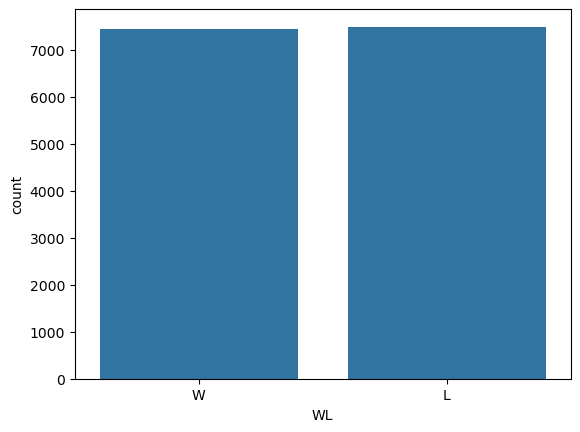

In [366]:
sns.countplot(x = 'WL',data = team_games_df)

Okay, seems obvious. Let's quickly change this column's values to a binary 0 and 1 (1 is W, 0 is L) so that we can throw this into a logistic regression model. 

In [367]:
team_games_df['WL'] = team_games_df['WL'].replace({'W':1,'L':0})
team_games_df.sample()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
22892,42014,1610612737,ATL,Atlanta Hawks,0041400201,2015-05-03,ATL vs. WAS,0,239,98,...,78.6,16,36,52,27,3,6,11,18,-6.0


Let's see how different stats are distributed:

Text(0.5, 0, 'Points scored in a game')

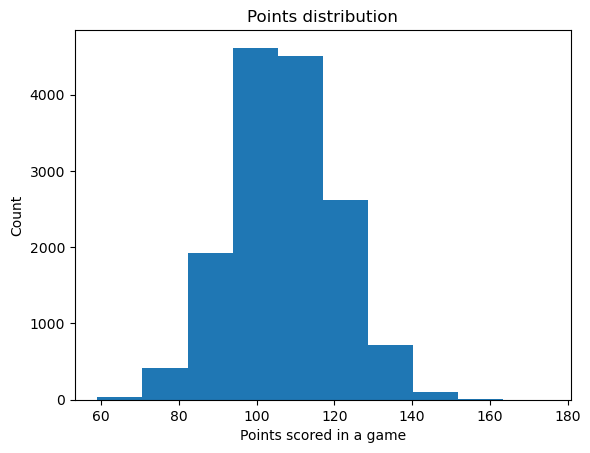

In [368]:
plt.hist(team_games_df['PTS'])
plt.title('Points distribution')
plt.ylabel('Count')
plt.xlabel('Points scored in a game')

Text(0.5, 0, 'Assists in a game')

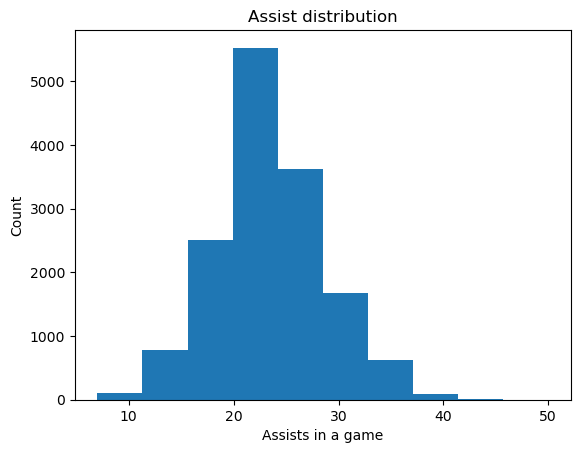

In [369]:
plt.hist(team_games_df['AST'])
plt.title('Assist distribution')
plt.ylabel('Count')
plt.xlabel('Assists in a game')

Text(0.5, 0, 'FG% in a game')

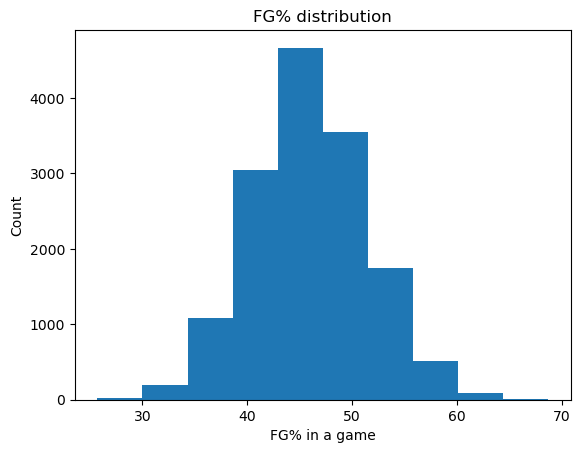

In [370]:
plt.hist(team_games_df['FG_PCT'])
plt.title('FG% distribution')
plt.ylabel('Count')
plt.xlabel('FG% in a game')

# Building Logistic Regression Model
Let's select the columns we are interested in. Why don't we get rid of everything but the statistical columns we think could be predictors. We also have to worry about multicollinearity. This arrticle here: https://statisticalhorizons.com/multicollinearity/ describes when we do and don't have to worry about certain variables. For our purposes, we'll just limit our model to those variables that are not obviously highly correlated. 

In [371]:
team_games_model_df = team_games_df.iloc[:,[7,9,11,12,14,15,17,18,19,20,22,23,24,25,26]]
team_games_model_df

,WL,PTS,FGA,FG_PCT,FG3A,FG3_PCT,FTA,FT_PCT,OREB,DREB,AST,STL,BLK,TOV,PF
4,1,129,92,54.3,26,30.8,26,80.8,7,34,27,7,4,11,18
5,1,120,82,48.8,34,41.2,32,81.3,10,33,25,6,4,14,17
7,1,119,84,47.6,32,37.5,35,77.1,13,43,27,5,7,14,17
8,0,114,90,44.4,41,34.1,25,80.0,14,33,28,5,2,15,21
9,0,115,90,47.8,32,40.6,21,76.2,13,30,24,4,1,12,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29993,1,110,88,44.3,18,33.3,32,81.3,10,33,26,12,4,14,22
29994,0,98,83,41.0,21,28.6,30,80.0,12,28,20,3,6,9,18
29997,0,93,72,43.1,15,33.3,38,68.4,10,28,20,8,8,13,18
29998,1,98,86,47.7,24,33.3,11,72.7,5,34,21,8,4,8,15


Okay, now we need to break away our column of predicted (`y_data`) values from our data frame. This is the column of values we're attempting to predict with our regression. The rest of the data, our predictors (`x_data`) will be everything except that 'WL' column.

In [372]:
y_data = team_games_model_df['WL']

x_data = team_games_model_df.drop('WL',axis = 1)

This next step of Train-Test splitting will be done by scikit-learn's built in function `train_test_split`.

In [373]:
from sklearn.model_selection import train_test_split
#test_size = .3, so 30% of data is in test set
#note output of tts func is list w/4 items, each a data frame w/ subset of values
x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(x_data, y_data, test_size = 0.3)

Next we must Standardize the scale of our features. Since `FG_PCT` is somewhere between 0.00 and 1.0 by definition, its influence on the outcome will be much lesser (if not scaled) than something like `PTS`, which has values into the hundreds. This is why we have to perform Feature Scaling with a machine learning model. 

In [374]:
from sklearn.preprocessing import StandardScaler
#create the scaler with the `StandardScaler` object from sklearn.preprocessing
sc = StandardScaler()
x_training_data = pd.DataFrame(sc.fit_transform(x_training_data))
x_test_data = pd.DataFrame(sc.transform(x_test_data))

Create the model with the `LogisticRegression` object from `sklearn.linearmodel`. Then simply run the fit method on that `model` object

In [375]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(x_training_data,y_training_data)



LogisticRegression()

# Predictions with Logistic Regression Model:
First we'll use the `.predict()` method on our model to create an array of binary outcome predictions based on our model. 

In [376]:
predictions = model.predict(x_test_data)


Then we will use the `classification_report` module from `scikit-learn` to measure our model performance. This is of course used for classification problems. 

In [377]:
from sklearn.metrics import classification_report
#takes first arg of actual outcomes, second arg of predicted outcomes
print(classification_report(y_test_data, predictions))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85      2225
           1       0.85      0.83      0.84      2254

    accuracy                           0.84      4479
   macro avg       0.84      0.84      0.84      4479
weighted avg       0.84      0.84      0.84      4479



### Interpreting coefficients:

Say that the variable PTS has a coefficient of .99. This means that for every unit increase in PTS, the expected change in log odds of winning a game is + .99, holding the other predictor variables constant at a certain value. 

This is the nature of a logistic regression, since 'When a binary outcome variable is modeled using logistic regression, it is assumed that the logit transformation of the outcome variable has a linear relationship with the predictor variables'. This guide here provides more detail and the source for this explanation: https://stats.oarc.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/.





In [381]:
#loop through as many ints as there are columns in our prediction data and print that column name with the model coefficient
for i in range(len(x_data.columns)):
    print(f'Variable: {x_data.columns[i]} Coefficient: {model.coef_[0][i]}.')

The variable 'PTS' has a coefficient of .99. This means that for every unit increase in 'PTS', the log odds of winning a game increase by .99.
Variable: PTS Coefficient: 1.7064819218613525.
Variable: FGA Coefficient: -2.142691324555013.
Variable: FG_PCT Coefficient: 0.4949955941448859.
Variable: FG3A Coefficient: -0.20419599402787117.
Variable: FG3_PCT Coefficient: 0.30744184670458524.
Variable: FTA Coefficient: -0.5248840093790419.
Variable: FT_PCT Coefficient: 0.1603307950626817.
Variable: OREB Coefficient: 1.2849645476229399.
Variable: DREB Coefficient: 1.969575849277096.
Variable: AST Coefficient: 0.18121052359898204.
Variable: STL Coefficient: 1.1090780372438491.
Variable: BLK Coefficient: 0.2907523983415261.
Variable: TOV Coefficient: -1.2367365854172847.
Variable: PF Coefficient: -0.17294289692691026.
